Description : Ce programme utilise un réseau neuronal artificiel récurrent appelant la mémoire à long terme (LSTM) pour prédire le cours de clôture d’une société (Apple Inc.) en utilisant le cours de l’action des 60 derniers jours.

In [ ]:
!pip install tensorflow

In [ ]:
!pip install pandas-datareader

In [ ]:
!pip install yfinance

In [ ]:
!pip install pyfolio

In [ ]:
# importer mes bibliothèques
import math
import pandas as pd
import numpy as np
import seaborn as sns 
from pandas_datareader import data as pdr
import yfinance as yf
import pandas_datareader.data as web
import datetime
import plotly.express as px
import plotly.figure_factory as ff
from scipy.stats import shapiro, jarque_bera, norm, linregress
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import pyfolio as pf 
#from pypfopt import EfficientFrontier
#from pypfopt import risk_models
#from pypfopt import expected_returns
import statsmodels.tsa.api as tsa
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
yf.pdr_override()

In [ ]:
# importer les données depuis l'API Alphavantage
df = web.get_data_yahoo('AAPL', start='2000-01-01', end='2020-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Afficher les données
df.style.background_gradient(cmap='coolwarm')

In [ ]:
# Nombre de lignes et de colonnes dans notre dataset
print('Nombre de lignes et de colonnes:', df.shape)

Nombre de lignes et de colonnes: (5283, 6)


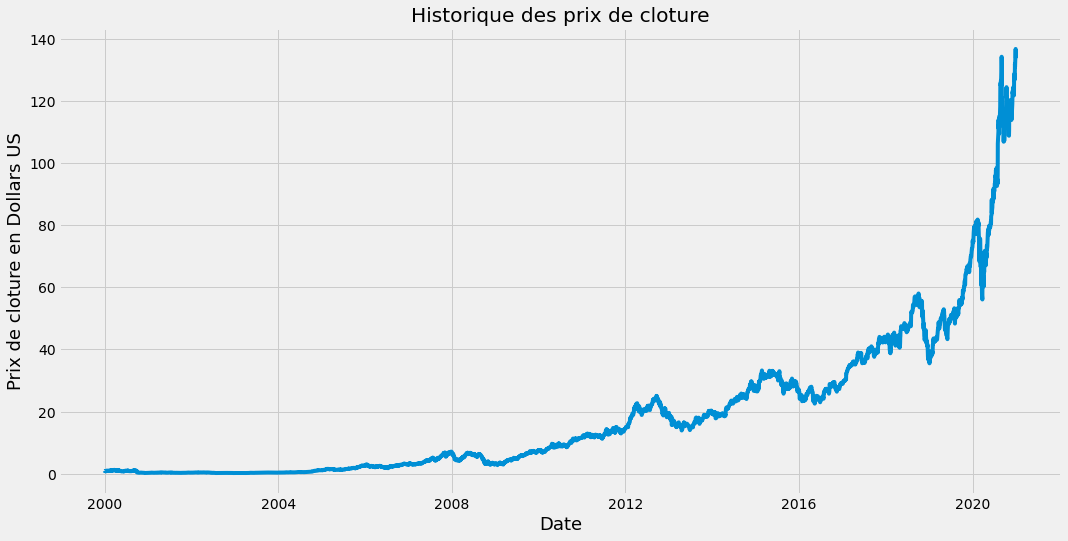

<Figure size 432x288 with 0 Axes>

In [ ]:
# Visualiser l'historique des prix de cloture de l'action Apple
plt.figure(figsize=(16,8))
plt.title('Historique des prix de cloture')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Prix de cloture en Dollars US', fontsize=18)
plt.show()
plt.savefig('Historique des prix de cloture')

In [ ]:
# Créer une nouvelle dataframe avec la colonne 'Close'
data = df.filter(['Close'])

# Convertir la dataframe en un tableau numpy
dataset = data.values

In [ ]:
# Afficher notre dataset
dataset

array([[  0.99944198],
       [  0.91517901],
       [  0.92857099],
       ...,
       [136.69000244],
       [134.86999512],
       [133.72000122]])

In [ ]:
# Obtenir le nombre de lignes pour l'entrainement du modèle 
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

4227

In [ ]:
# Normaliser les données avec la fonction MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00560736],
       [0.00498985],
       [0.00508799],
       ...,
       [1.        ],
       [0.98666229],
       [0.97823469]])

In [ ]:
# Créer les données d'entrainement
# Créer les données d'entrainement normalisées
train_data = scaled_data[0:training_data_len , :]

# Diviser les données de notre dataset en x_train et y_train      
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

  if i<= 61:
    print(x_train)
    print(y_train)
    print()


[array([0.00560736, 0.00498985, 0.00508799, 0.0044991 , 0.00479355,
       0.00467904, 0.00435188, 0.00398792, 0.00461361, 0.00485489,
       0.0050839 , 0.00525566, 0.0057096 , 0.00556647, 0.00523522,
       0.0056278 , 0.00549285, 0.00548058, 0.00493259, 0.00507163,
       0.00484262, 0.00474856, 0.00504301, 0.00534972, 0.0057464 ,
       0.00579957, 0.00565234, 0.0057096 , 0.00539879, 0.0058609 ,
       0.00606947, 0.00575049, 0.00579957, 0.00556238, 0.00573004,
       0.00588953, 0.00582103, 0.00550512, 0.00569324, 0.00578321,
       0.00680967, 0.00626577, 0.00665836, 0.00650705, 0.00632302,
       0.00626577, 0.00628213, 0.00651114, 0.00622078, 0.00575867,
       0.00588953, 0.00623714, 0.00646206, 0.0063312 , 0.00711229,
       0.00771754, 0.00752942, 0.00735766, 0.00741492, 0.00738629])]
[0.007177727552901097]

[array([0.00560736, 0.00498985, 0.00508799, 0.0044991 , 0.00479355,
       0.00467904, 0.00435188, 0.00398792, 0.00461361, 0.00485489,
       0.0050839 , 0.00525566, 0.0

In [ ]:
# Convertir le x_train et y_train en tableau numpy
x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
# Redimensionner nos données 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
# Construire le modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Entrainer le modèle
model.fit(x_train, y_train, batch_size=1, epochs=1)

4167/4167 [==============================] - 122s 28ms/step - loss: 7.4350e-05


In [ ]:
# Créer les données de test
# Créer un nouveau tableau contenant les valeurs mises à l'échelle de l'index 1543 à 2003
test_data = scaled_data[training_data_len - 60: , :]

# Créer les jeux de données x_test et y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
# Créer les données en tableau numpy
x_test = np.array(x_test)

In [ ]:
# Redimensionner les données 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [ ]:
# Obtenir les prix prédits par les modèles 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
# Obtenir les métriques de performance de notre modèle
rmse = np.sqrt(np.mean(predictions - y_test)**2)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test,predictions,multioutput='uniform_average')

print('le score RMSE est de :{}'.format(rmse))
print('le score MSE est de :{}'.format(mse))
print('le score MAE est de : {}'.format(mae))

le score RMSE est de :0.9714118386759902
le score MSE est de :5.5494577509472025
le score MAE est de : 1.6686107100862446


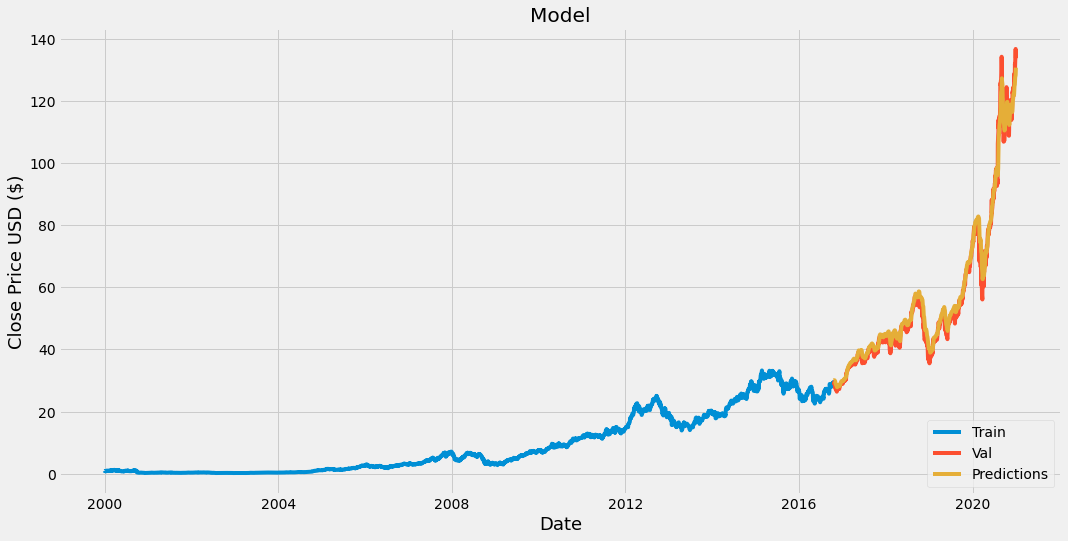

In [ ]:
# Dessinons les données
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

# Visualiser les données 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()

In [ ]:
# Afficher les prix de cloture de test et les prix de cloture prédits
valid

Close  predictions
Date                               
2016-10-20   29.264999    30.024351
2016-10-21   29.150000    30.042496
2016-10-24   29.412500    30.031290
2016-10-25   29.562500    30.051466
2016-10-26   28.897499    30.104645
...                ...          ...
2020-12-23  130.960007   126.693390
2020-12-24  131.970001   127.512726
2020-12-28  136.690002   128.294968
2020-12-29  134.869995   129.639786
2020-12-30  133.720001   130.677261

[1056 rows x 2 columns]

In [ ]:
apple_quote= web.DataReader('AAPL', data_source='yahoo', start='2000-01-01', end='2020-12-31')
# Créer une nouvelle dataframe
new_df= apple_quote.filter(['Close'])

# Obtenir les derniers 60 jours des prix de cloture et convertir la dataframe en array
last_60_days = new_df[-60:].values 

# Mettre à l'échelle les données entre 0 et 1
last_60_days_scaled= scaler.transform(last_60_days)

# Créer une liste vide
X_test = []

# Ajouter les 60 jours passés
X_test.append(last_60_days_scaled)

# Les convertir en numpy array
X_test = np.array(X_test)

# Redimensionner les données 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Obtenir les données prédites mises à l'échelle
pred_price = model.predict(X_test)

# Defaire le scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


[*********************100%***********************]  1 of 1 completed
[[131.25487]]


In [ ]:
df_check = web.get_data_yahoo('AAPL', start='2021-01-04', end='2021-01-05')

[*********************100%***********************]  1 of 1 completed


In [ ]:
df_check.head()

Open        High  ...   Adj Close     Volume
Date                                ...                       
2021-01-04  133.520004  133.610001  ...  128.617111  143301900

[1 rows x 6 columns]

In [ ]:
reel = 131.25487
pred_future = 129.410004

In [ ]:
rmse1 = np.sqrt(np.mean(reel - pred_future)**2)
print(rmse1)

1.8448660000000245
